/tmp/ipython-input-3221679318.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data['time'] = pd.date_range(start='1949-01', periods=len(data), freq='M')


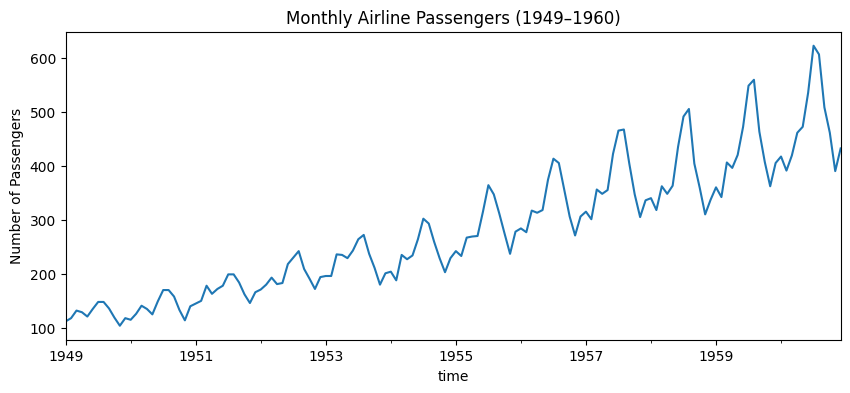

<Figure size 1000x800 with 0 Axes>

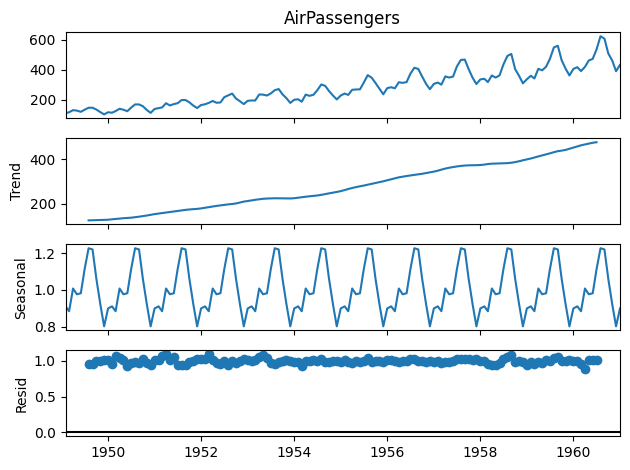

In [ ]:
# --- Import libraries ---
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from statsmodels.tsa.seasonal import seasonal_decompose

# --- Load the AirPassengers dataset ---
# It contains monthly totals of international airline passengers, 1949–1960
data = get_rdataset('AirPassengers').data

# Convert to a time series
data['time'] = pd.date_range(start='1949-01', periods=len(data), freq='M')
ts = pd.Series(data['value'].values, index=data['time'])
ts.name = 'AirPassengers'

# --- Plot the original series ---
plt.figure(figsize=(10, 4))
ts.plot(title='Monthly Airline Passengers (1949–1960)')
plt.ylabel('Number of Passengers')
plt.show()

# --- Decompose the time series ---
result = seasonal_decompose(ts, model='multiplicative', period=12)

# --- Plot the decomposition ---
plt.figure(figsize=(10, 8))
result.plot()
#plt.suptitle('Decomposition of Airline Passenger Data', fontsize=16)
plt.show()

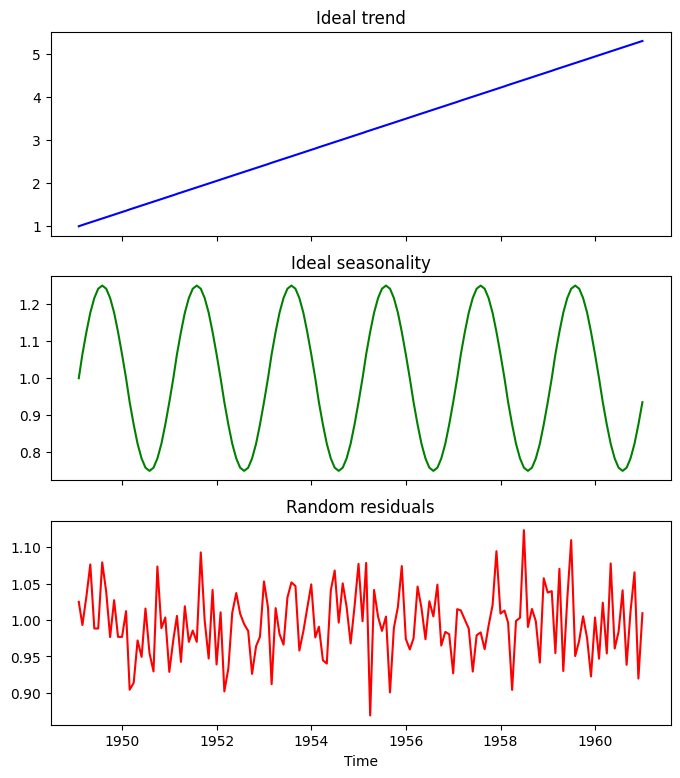

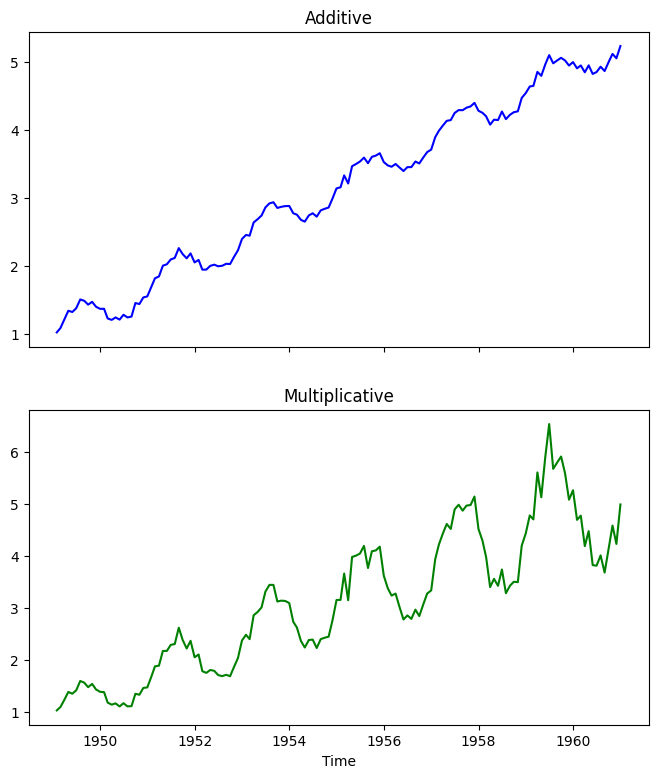

In [ ]:
data_ex = data.copy()
data_ex.set_index('time', inplace=True)
t = np.arange(len(data))
np.random.seed(42)

data_ex['Trend'] = 0.03 * t + 1
data_ex['Seasonality'] = 1 + np.sin(np.pi * t/12)/4
data_ex['Residuals'] = 1 + np.random.normal(loc=0, scale=0.05, size=len(data))

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 9), sharex=True)

# Trend
axes[0].plot(data_ex.index, data_ex['Trend'], color='blue')
axes[0].set_title('Ideal trend')

# Seasonality
axes[1].plot(data_ex.index, data_ex['Seasonality'], color='green')
axes[1].set_title('Ideal seasonality')

# Residuals
axes[2].plot(data_ex.index, data_ex['Residuals'], color='red')
axes[2].set_title('Random residuals')
axes[2].set_xlabel('Time')

plt.show()

data_ex['Additive'] = data_ex['Seasonality'] + data_ex['Trend'] + data_ex['Residuals']-2
data_ex['Multiplicative'] = data_ex['Seasonality'] * data_ex['Residuals'] * data_ex['Trend']

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 9), sharex=True)

# Trend
axes[0].plot(data_ex.index, data_ex['Additive'], color='blue')
axes[0].set_title('Additive')

# Seasonality
axes[1].plot(data_ex.index, data_ex['Multiplicative'], color='green')
axes[1].set_title('Multiplicative')
axes[1].set_xlabel('Time')

plt.show()

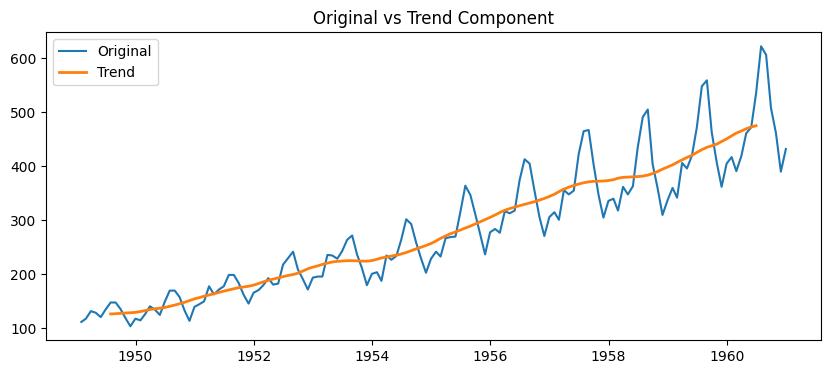

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(ts, label='Original')
plt.plot(result.trend, label='Trend', linewidth=2)
plt.legend()
plt.title('Original vs Trend Component')
plt.show()

<Axes: title={'center': 'Seasonal Pattern (1 Year)'}, xlabel='time'>

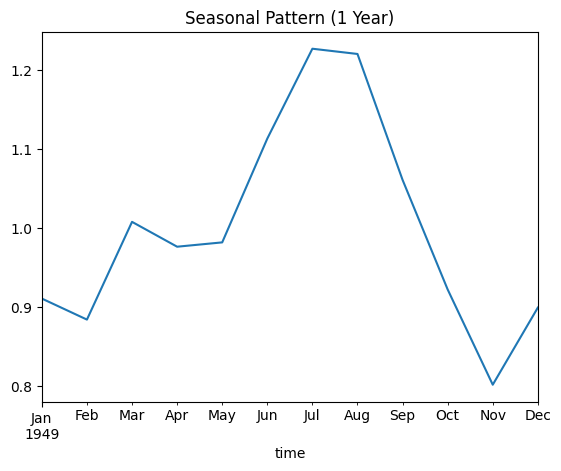

In [ ]:
result.seasonal[:12].plot(title='Seasonal Pattern (1 Year)')

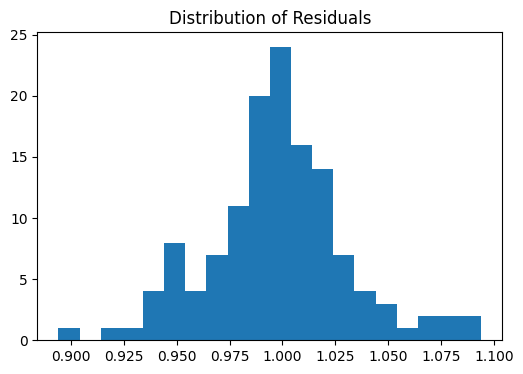

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(result.resid.dropna(), bins=20)
plt.title('Distribution of Residuals')
plt.show()


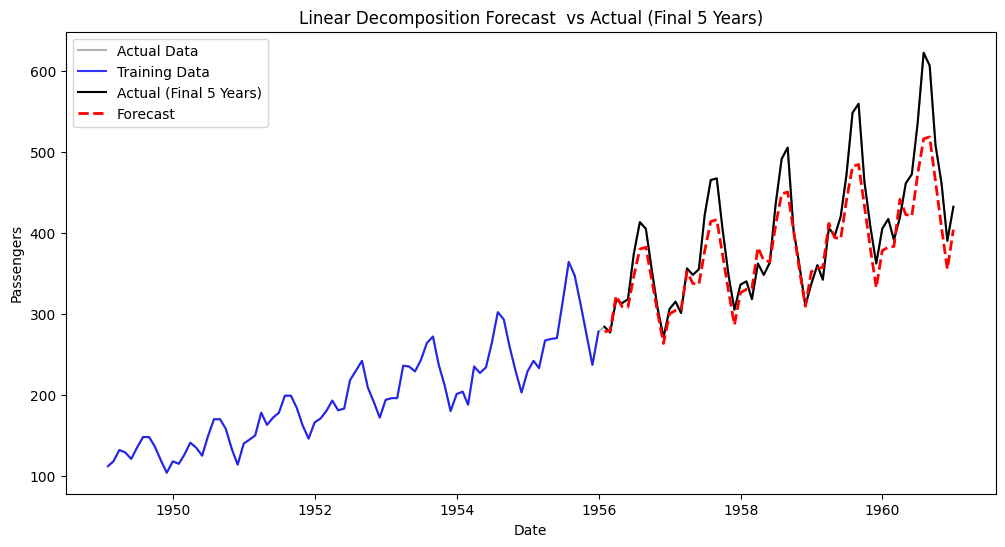

In [ ]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression

# --- Split: train on all but last 5 years ---
train = ts[:-60]
test = ts[-60:]

# --- Decompose training data ---
result = seasonal_decompose(train, model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal
trend_index = np.arange(len(trend)).reshape(-1, 1)

# --- Fit linear regression to the trend ---
model = LinearRegression().fit(trend_index, trend.values)

# --- Forecast the trend for 5 years (same length as test) ---
future_index = np.arange(len(trend), len(trend) + len(test)).reshape(-1, 1)
trend_forecast = model.predict(future_index).flatten()

# --- Extend seasonal pattern for forecast period ---
seasonal_cycle = seasonal[-12:].values
seasonal_forecast = np.tile(seasonal_cycle, int(np.ceil(len(test)/12)))[:len(test)]

# --- Recompose (multiplicative) ---
forecast = trend_forecast * seasonal_forecast
forecast_series = pd.Series(forecast, index=test.index)

# Compute adjustment ratio at the join point
last_train = train.iloc[-1]
first_forecast = forecast_series.iloc[0]
adjustment_ratio = last_train / first_forecast

forecast_series *= adjustment_ratio  # scale forecast upward

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(ts, label='Actual Data', color='gray', alpha=0.6)
plt.plot(train.index, train, color='blue', alpha=0.8, label='Training Data')
plt.plot(test.index, test, color='black', label='Actual (Final 5 Years)')
plt.plot(forecast_series, color='red', linestyle='--', linewidth=2, label='Forecast')
plt.title('Linear Decomposition Forecast  vs Actual (Final 5 Years)')
plt.ylabel('Passengers')
plt.xlabel('Date')
plt.legend()
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


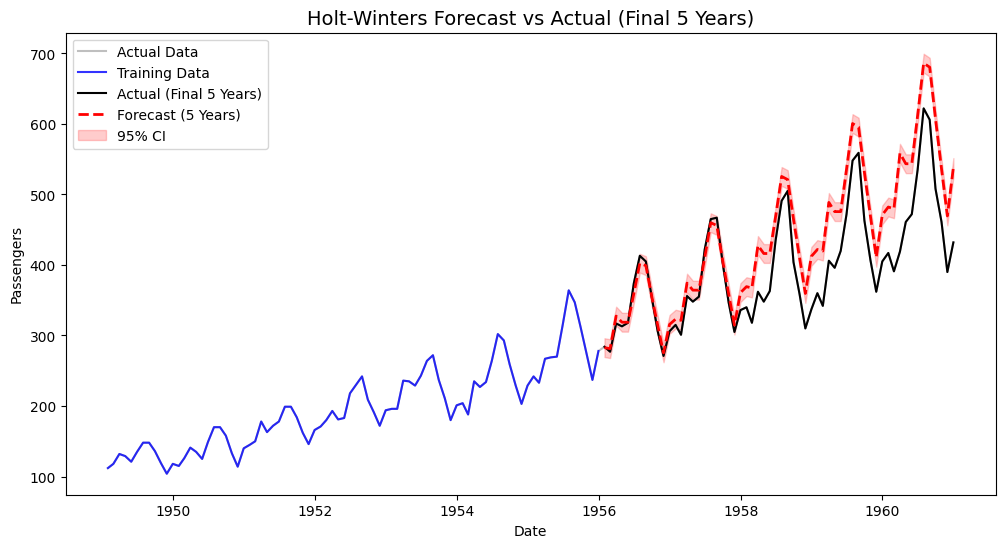

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- Train/Test Split (last 5 years for testing) ---
train = ts[:-60]
test = ts[-60:]

# --- Fit Holt-Winters model ---
hw_model = ExponentialSmoothing(
    train,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12
).fit()

# --- Forecast same length as test ---
forecast_values = hw_model.forecast(len(test))

# --- Compute approximate confidence intervals ---
resid_std = np.std(hw_model.resid)
ci_upper = forecast_values + 1.96 * resid_std
ci_lower = forecast_values - 1.96 * resid_std

# --- Plot forecast vs actual ---
plt.figure(figsize=(12,6))
plt.plot(ts, color='gray', alpha=0.5, label='Actual Data')
plt.plot(train.index, train, color='blue', alpha=0.8, label='Training Data')
plt.plot(test.index, test, color='black', label='Actual (Final 5 Years)')
plt.plot(forecast_values, color='red', linestyle='--', linewidth=2, label='Forecast (5 Years)')
plt.fill_between(test.index, ci_lower, ci_upper, color='red', alpha=0.2, label='95% CI')

plt.title('Holt-Winters Forecast vs Actual (Final 5 Years)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()
